<a href="https://colab.research.google.com/github/patrick-seib/econ-489/blob/main/489_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base import  datetools

drive.mount('/content/drive/', force_remount=True)
data = pd.read_csv('/content/drive/My Drive/489_Data/final_cleaned_data.csv')

Mounted at /content/drive/


Notes: Look at the first differences (rates of change) instead of looking at just levels, and compare recent rates of changes to historical levels of rates of change
- Look at rate of change for VAR, don't reverse the differencing
- compare rate of increase in household final expenditure to current household final consumption expenditure
- work on gov and housing also but make this better

also: always write a little blurb about interpretation -> what do we think about this

In [28]:
# Data info: Seasonally adjusted by Annual rates, using chained 2012, data from Q1 1991 -> Q2 2023
metadata = [
    "Household final consumption expenditure  [C<<OutputTruncated>>",
    "1",
    "How to cite: Statistics Canada. Table 36-10-0107-01\xa0 Household final consumption expenditure, quarterly, Canada (x 1,000,000)",
    "https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610010701"
]

In [58]:
# Convert every column except 'Quarter' to numeric data
df_numeric = data
cols_to_convert = df_numeric.columns.difference(['Quarter'])
df_numeric[cols_to_convert] = df_numeric[cols_to_convert].applymap(lambda x: pd.to_numeric(str(x).replace(',', ''), errors='coerce'))

# Display the first few rows to verify the transformation
df_numeric.to_csv('/content/drive/My Drive/489_Data/final_cleaned_data.csv')


,Quarter,Food and non-alcoholic beverages [C11],Food [C111],Non-alcoholic beverages [C112],"Alcoholic beverages, tobacco and cannabis [C12]",Alcoholic beverages [C121],Tobacco [C122],Cannabis [C123],Clothing and footwear [C13],Clothing [C131],...,Net expenditure abroad [C25],Expenditure by Canadians abroad [C251],Expenditure by non-residents in Canada [C252],Household final consumption expenditure [C],Goods [CG],Durable goods [CD],Semi-durable goods [CSD],Non-durable goods [CND],Services [CS],Pct_Change
0,1991Q1,65860.0,59560.0,6402.0,33420.0,12419.0,20548.0,2955.0,20116.0,17227.0,...,3302.0,19741.0,-16439.0,534089.0,245060.0,48131.0,31456.0,176720.0,288670.0,NaN
1,1991Q2,65839.0,59545.0,6397.0,32602.0,12201.0,19753.0,2951.0,20526.0,17503.0,...,4881.0,20601.0,-15720.0,543037.0,250904.0,51971.0,32118.0,176880.0,291444.0,1.675376
2,1991Q3,66006.0,59671.0,6433.0,32269.0,12056.0,19517.0,2948.0,20117.0,17123.0,...,5551.0,21435.0,-15884.0,542556.0,249439.0,51330.0,31715.0,176740.0,292659.0,-0.088576
3,1991Q4,66344.0,59930.0,6504.0,31933.0,11831.0,19370.0,2951.0,20134.0,17171.0,...,8625.0,24027.0,-15402.0,545614.0,247976.0,49261.0,32014.0,177602.0,297688.0,0.563628
4,1992Q1,66494.0,60159.0,6442.0,31729.0,11989.0,18899.0,2952.0,19918.0,16996.0,...,5588.0,22065.0,-16477.0,545600.0,248571.0,49893.0,31701.0,177903.0,296979.0,-0.002566


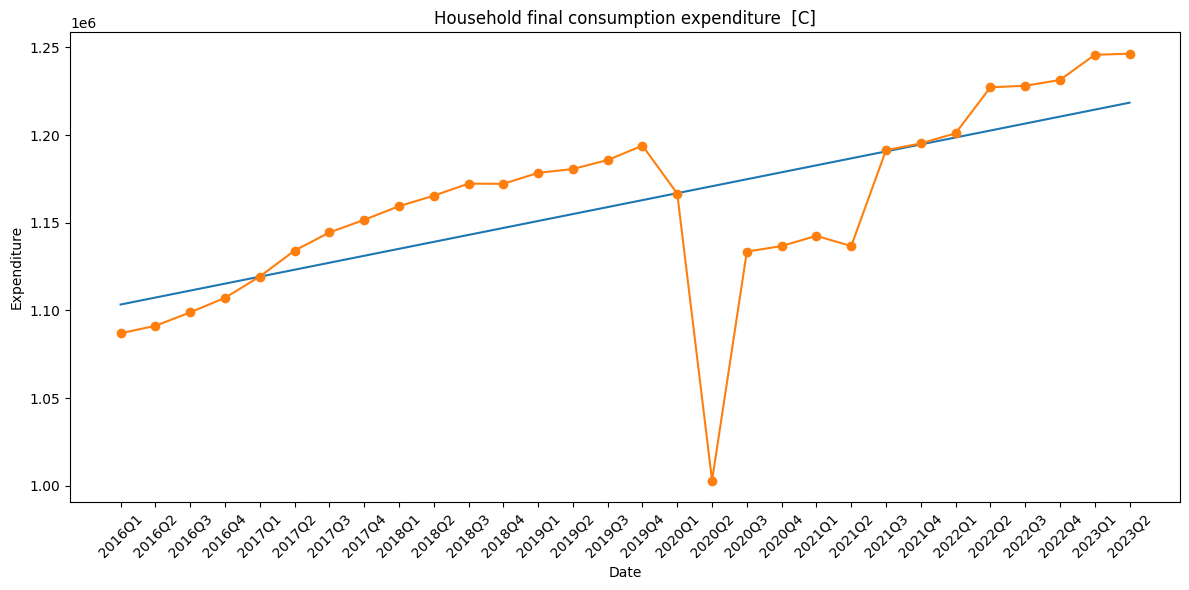

In [30]:
# Plotting
x = np.array([d for d in data.index[100:]])
y = data['Household final consumption expenditure  [C]'][100:].values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)


plt.figure(figsize=(12, 6))
plt.plot(data['Quarter'][100:], p(x), label='Trend Line')
plt.plot(data['Quarter'][100:], data['Household final consumption expenditure  [C]'][100:], marker='o', linestyle='-')
plt.title('Household final consumption expenditure  [C]')
plt.xlabel('Date')
plt.ylabel('Expenditure')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


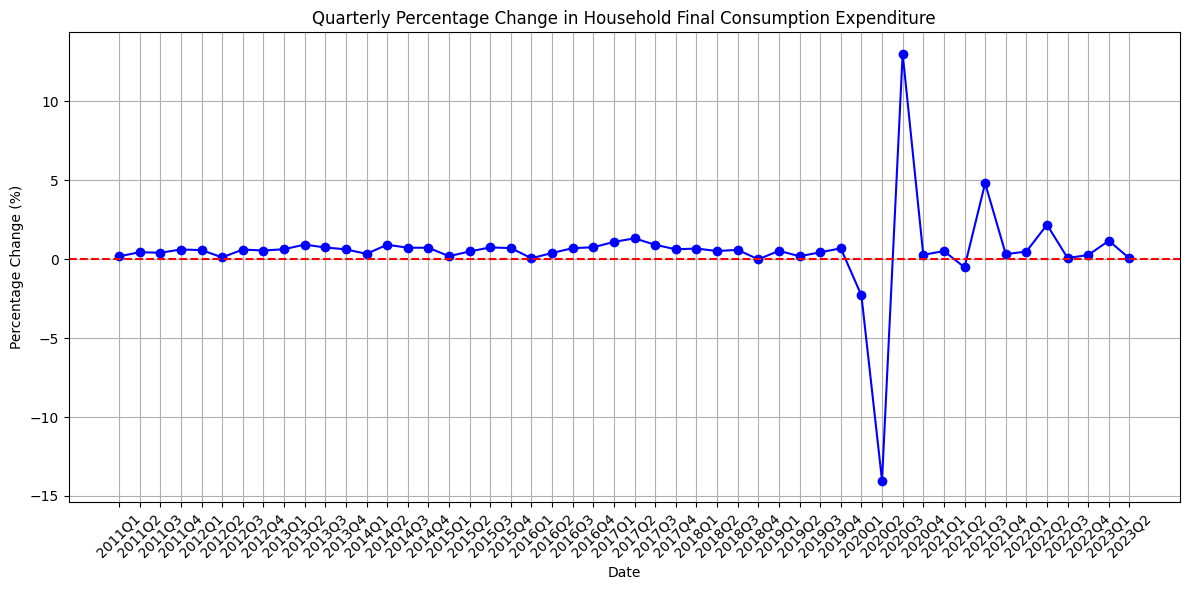

In [31]:
# Calculate the percentage change for each quarter
data['Pct_Change'] = data['Household final consumption expenditure  [C]'].pct_change() * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Quarter'][80:], data['Pct_Change'][80:], marker='o', linestyle='-', color='b')
plt.title('Quarterly Percentage Change in Household Final Consumption Expenditure')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [32]:
df_reloaded = data.copy()
feature_totals_corrected = df_reloaded.drop(columns="Household final consumption expenditure  [C]").sum(axis=0)
feature_totals_corrected = pd.to_numeric(feature_totals_corrected, errors='coerce')

feature_share_corrected = feature_totals_corrected / feature_totals_corrected.sum()

top_5_features_corrected = feature_share_corrected.sort_values(ascending=False).head(5)
top_5_features_corrected

Services  [CS]                                             0.157071
Goods  [CG]                                                0.131033
Non-durable goods  [CND]                                   0.077866
Housing, water, electricity, gas and other fuels  [C14]    0.069102
Transport  [C17]                                           0.043330
dtype: float64

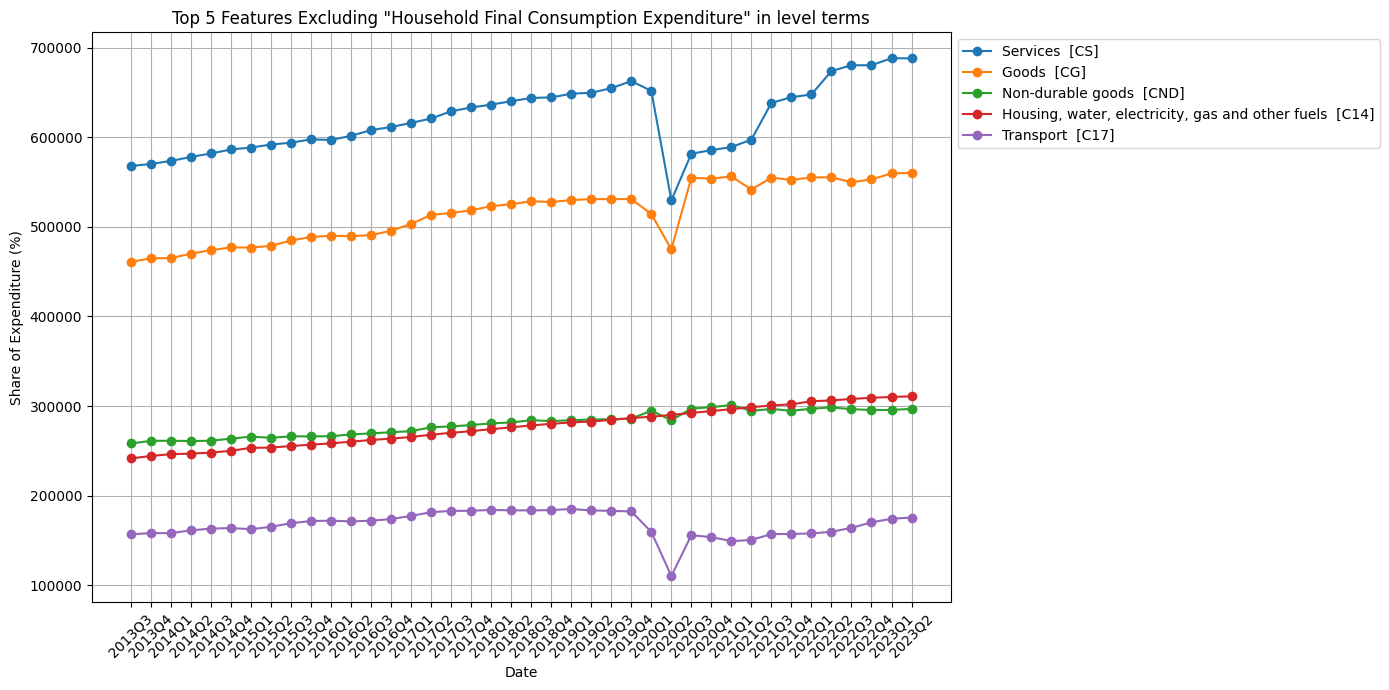

In [33]:
# Exclude "Household final consumption expenditure" and find the next top 5 features
data_filtered = data.copy()

plt.figure(figsize=(14, 7))
for feature in top_5_features_corrected.index:
    plt.plot(data_filtered['Quarter'][90:], data_filtered[feature][90:], marker='o', label=feature)

plt.title('Top 5 Features Excluding "Household Final Consumption Expenditure" in level terms')
plt.xlabel('Date')
plt.ylabel('Share of Expenditure (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [34]:
quarterly_totals = data_filtered.sum(axis=1)
data_filtered.set_index("Quarter")
# Convert all values in df_filtered to numeric
cols_to_convert = df_numeric.columns.difference(['Quarter'])
df_numeric[cols_to_convert] = df_numeric[cols_to_convert].applymap(pd.to_numeric, errors='coerce')

# Calculate the share of each feature for each quarter
df_share_corrected = df_numeric[cols_to_convert].divide(quarterly_totals, axis=0) * 100

<ipython-input-34-890d8539a8f8>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  quarterly_totals = data_filtered.sum(axis=1)


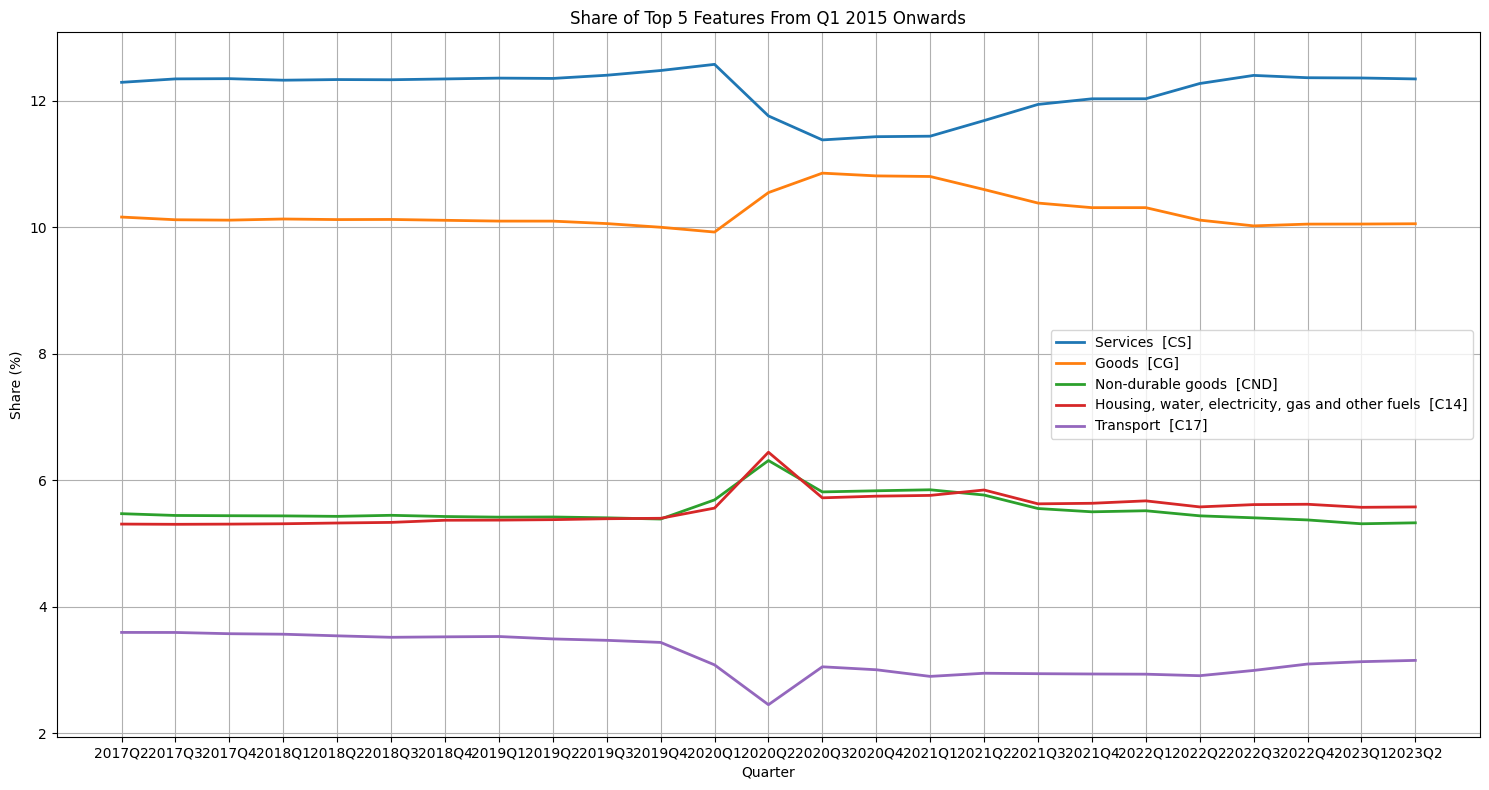

In [35]:
# Compute the total for each quarter
# Plotting the share of the top 5 features from 'Q1 2015' onwards
plt.figure(figsize=(15, 8))

for feature in top_5_features_corrected.index:
    plt.plot(data['Quarter'][105:], df_share_corrected[feature][105:], label=feature, linewidth=2)

plt.title('Share of Top 5 Features From Q1 2015 Onwards')
plt.xlabel('Quarter')
plt.ylabel('Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Creating a VAR for predicting future Household consumption

In [44]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationarity(timeseries):
    # Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05

# Check stationarity for 'Household final consumption expenditure [C]'
is_stationary = test_stationarity(data['Household final consumption expenditure  [C]'][40:])

# Convert data columns to float, excluding the "Quarters" column
data.iloc[:, 1:] = data.iloc[:, 1:].astype(float)

is_stationary = test_stationarity(data['Household final consumption expenditure  [C]'][40:])

is_stationary


False

In [46]:
# Forecast the next 5 steps
forecast = var_model_fitted.forecast(data_differenced.values[-var_model_fitted.k_ar:], steps=5)

# Convert forecasted values to a DataFrame for better visualization
forecast_df = pd.DataFrame(forecast, columns=data_differenced.columns)

<ipython-input-47-800c1e53cdf1>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_values = data['Household final consumption expenditure  [C]'].append(forecast_actual['Household final consumption expenditure  [C]'])


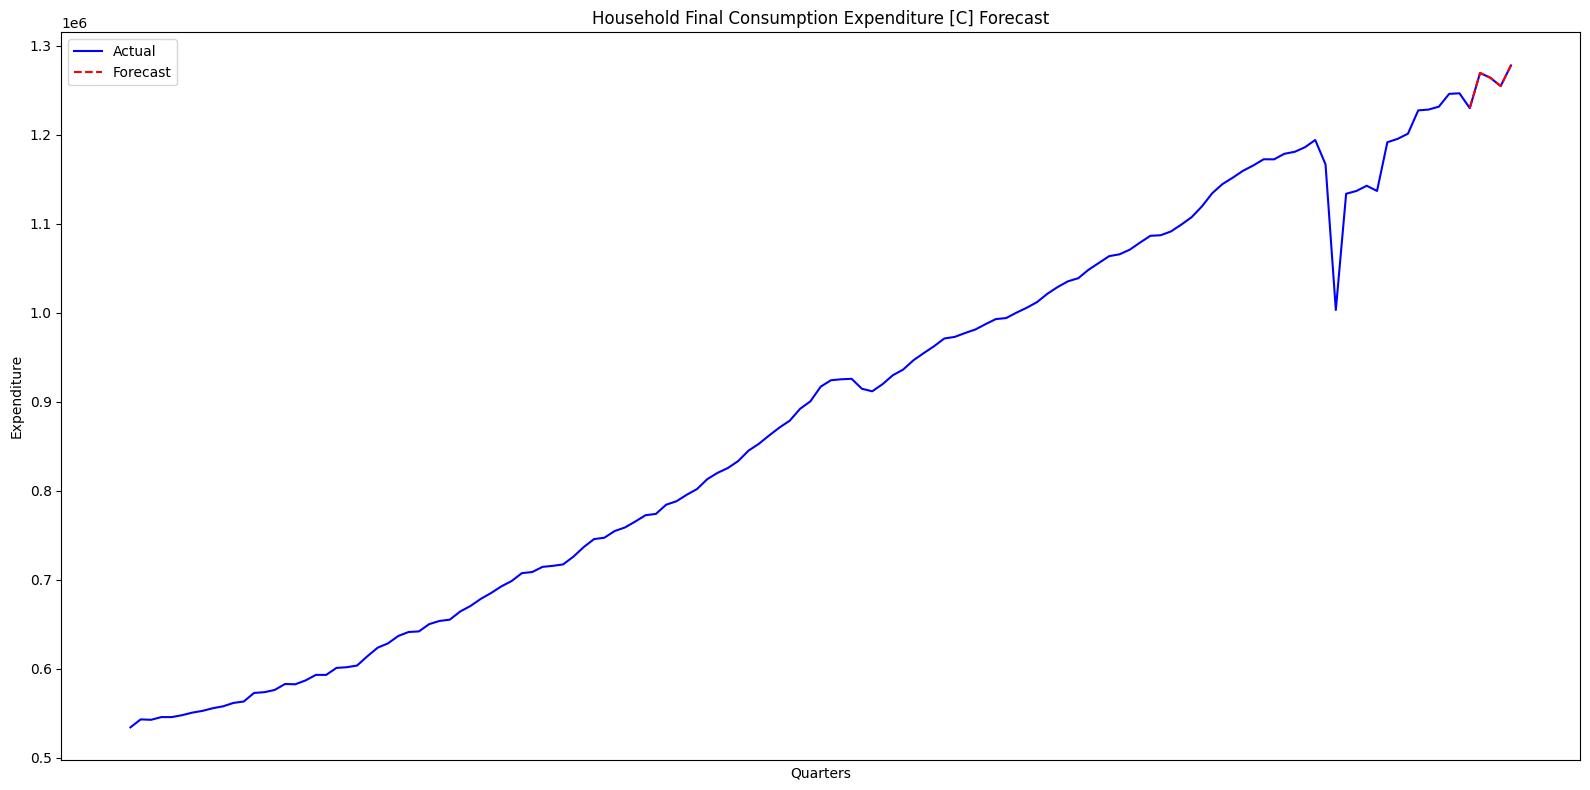

In [47]:
# Convert combined index to string for consistent plotting
forecast_index = ['Forecast 1', 'Forecast 2', 'Forecast 3', 'Forecast 4', 'Forecast 5']
forecast_actual = forecast_df.cumsum().add(data[features_to_difference].iloc[-1].values)

combined_index = data.index.append(pd.Index(forecast_index))
combined_values = data['Household final consumption expenditure  [C]'].append(forecast_actual['Household final consumption expenditure  [C]'])


combined_index_str = combined_index.astype(str)

# Plot the combined data
plt.figure(figsize=(16, 8))
plt.plot(combined_index_str, combined_values, label='Actual', color='blue')
plt.plot(forecast_index, forecast_actual['Household final consumption expenditure  [C]'].values, label='Forecast', color='red', linestyle='--')

plt.title('Household Final Consumption Expenditure [C] Forecast')
plt.xlabel('Quarters')
plt.ylabel('Expenditure')
plt.xticks([])
plt.legend()
plt.tight_layout()
plt.show()


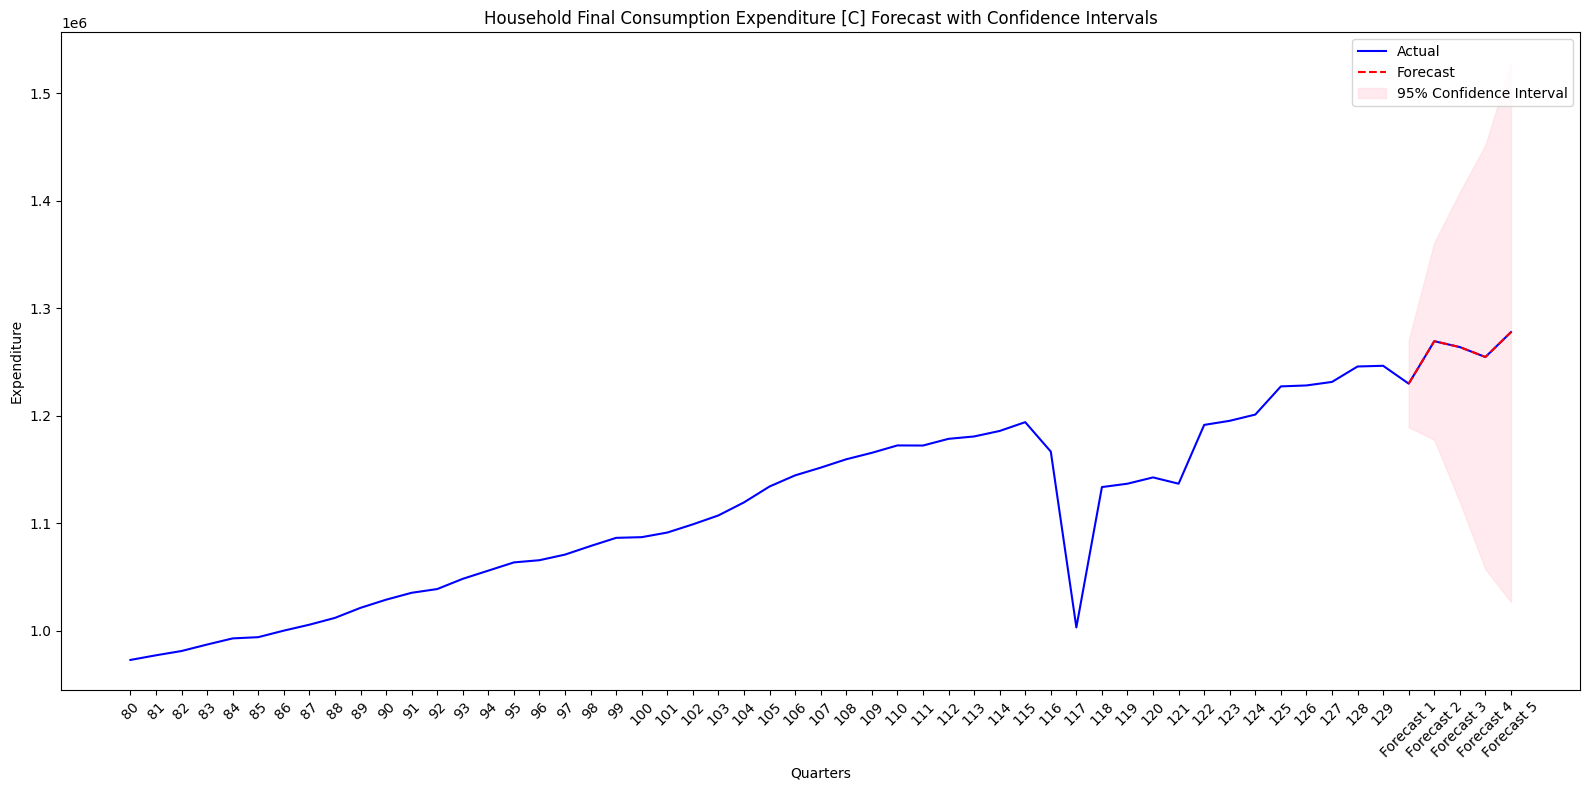

,Household final consumption expenditure [C],Health [C16],Services [CS]
0,-16632.589010,-1016.862340,-13942.064113
1,39516.068870,1734.458898,21022.314404
2,-5478.349038,-269.465403,-690.994241
3,-9254.478208,-585.789641,-10192.092263
4,23163.155519,1329.555642,13766.529632


In [56]:
# Compute forecast with confidence intervals
forecast_with_ci = var_model_fitted.forecast_interval(data_differenced.values[-var_model_fitted.k_ar:], steps=5)

# Convert forecasted values with confidence intervals to a DataFrame for better visualization
forecast_lower = pd.DataFrame(forecast_with_ci[1], columns=data_differenced.columns)
forecast_upper = pd.DataFrame(forecast_with_ci[2], columns=data_differenced.columns)

# Reverse the differencing to get the actual forecasted values with confidence intervals
forecast_lower_actual = forecast_lower.cumsum().add(data[features_to_difference].iloc[-1].values)
forecast_upper_actual = forecast_upper.cumsum().add(data[features_to_difference].iloc[-1].values)


# Plot the combined data with confidence intervals
plt.figure(figsize=(16, 8))
plt.plot(combined_index_str[80:], combined_values[80:], label='Actual', color='blue')
plt.plot(forecast_index, forecast_actual['Household final consumption expenditure  [C]'].values, label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast_index, forecast_lower_actual['Household final consumption expenditure  [C]'],
                 forecast_upper_actual['Household final consumption expenditure  [C]'], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Household Final Consumption Expenditure [C] Forecast with Confidence Intervals')
plt.xlabel('Quarters')
plt.ylabel('Expenditure')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
forecast_df


In [3]:
data.set_index('Quarter', inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the target variable
result = adfuller(data['Household final consumption expenditure  [C]'])

# Extract the test statistic and the p-value
test_statistic, p_value = result[0], result[1]
print(test_statistic, p_value)

# Difference the series
data['Household final consumption expenditure  [C]_diff'] = data['Household final consumption expenditure  [C]'].diff()

# Drop the NaN value created due to differencing
data.dropna(subset=['Household final consumption expenditure  [C]_diff'], inplace=True)

# Perform ADF test on the differenced series
result_diff = adfuller(data['Household final consumption expenditure  [C]_diff'])

# Extract the test statistic and the p-value for the differenced series
test_statistic_diff, p_value_diff = result_diff[0], result_diff[1]

test_statistic_diff, p_value_diff



0.1748947672740449 0.9708178396692788


(-11.10102825982541, 3.8650213465653824e-20)

In [5]:
# Split the data into training and testing datasets (80% training and 20% testing)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

from statsmodels.tsa.api import VAR

# Compute the correlation matrix
correlation_matrix = train.corr()

# Get absolute correlations with the target variable
correlations_with_target = correlation_matrix['Household final consumption expenditure  [C]'].abs()

# Sort the correlations and get the top 6 features
top_6_features = correlations_with_target.sort_values(ascending=False).index[1:7].tolist()  # Exclude the target itself

top_6_features


['Services  [CS]',
 'Goods  [CG]',
 'Health  [C16]',
 'Medical products, appliances and equipment  [C161]',
 'Semi-durable goods  [CSD]',
 'Other recreational items and equipment, garden products and pets  [C193]']

In [10]:
# Create a reduced dataset with the top 6 features and the differenced target variable
reduced_train = train[top_6_features + ['Household final consumption expenditure  [C]_diff']]
reduced_test = test[top_6_features + ['Household final consumption expenditure  [C]_diff']]

# Refit the VAR model using the entire dataset and forecast the next 5 periods
model_final_corrected = VAR(data[top_6_features + ['Household final consumption expenditure  [C]_diff']])
fitted_model_final_corrected = model_final_corrected.fit(optimal_lag_reduced_dataset)

# Forecast the next 5 periods
forecast_final_corrected = fitted_model_final_corrected.forecast(data[top_6_features + ['Household final consumption expenditure  [C]_diff']].values[-optimal_lag_reduced_dataset:], steps=5)

# Convert the forecast to a DataFrame
forecast_final_corrected_df = pd.DataFrame(forecast_final_corrected, columns=data[top_6_features + ['Household final consumption expenditure  [C]_diff']].columns)

# Calculate the forecasted percentage rate of change for the next 5 periods
forecasted_pct_change_final_corrected = (forecast_final_corrected_df["Household final consumption expenditure  [C]_diff"] / data['Household final consumption expenditure  [C]'].iloc[-1]) * 100

# Update the index to represent the forecasted periods
forecasted_periods_corrected = ["2023Q3", "2023Q4", "2024Q1", "2024Q2", "2024Q3"]
forecasted_pct_change_final_corrected.index = forecasted_periods_corrected

forecasted_pct_change_final_corrected

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


2023Q3    1.208641
2023Q4    0.038679
2024Q1    0.229086
2024Q2    0.036682
2024Q3    0.133633
Name: Household final consumption expenditure  [C]_diff, dtype: float64

In [11]:
# Calculate the average percentage rate of change for the entire dataset
average_pct_change = (data['Household final consumption expenditure  [C]_diff'] / data['Household final consumption expenditure  [C]'].shift(1)).mean() * 100

average_pct_change

0.6681982873159982

In [12]:
# Compare the forecasted percentage rates of change with the average value
comparison_with_average = forecasted_pct_change_final_corrected > average_pct_change

comparison_results = pd.DataFrame({
    'Forecasted_Pct_Change': forecasted_pct_change_final_corrected,
    'Above_Average': comparison_with_average
})

comparison_results

,Forecasted_Pct_Change,Above_Average
2023Q3,1.208641,True
2023Q4,0.038679,False
2024Q1,0.229086,False
2024Q2,0.036682,False
2024Q3,0.133633,False


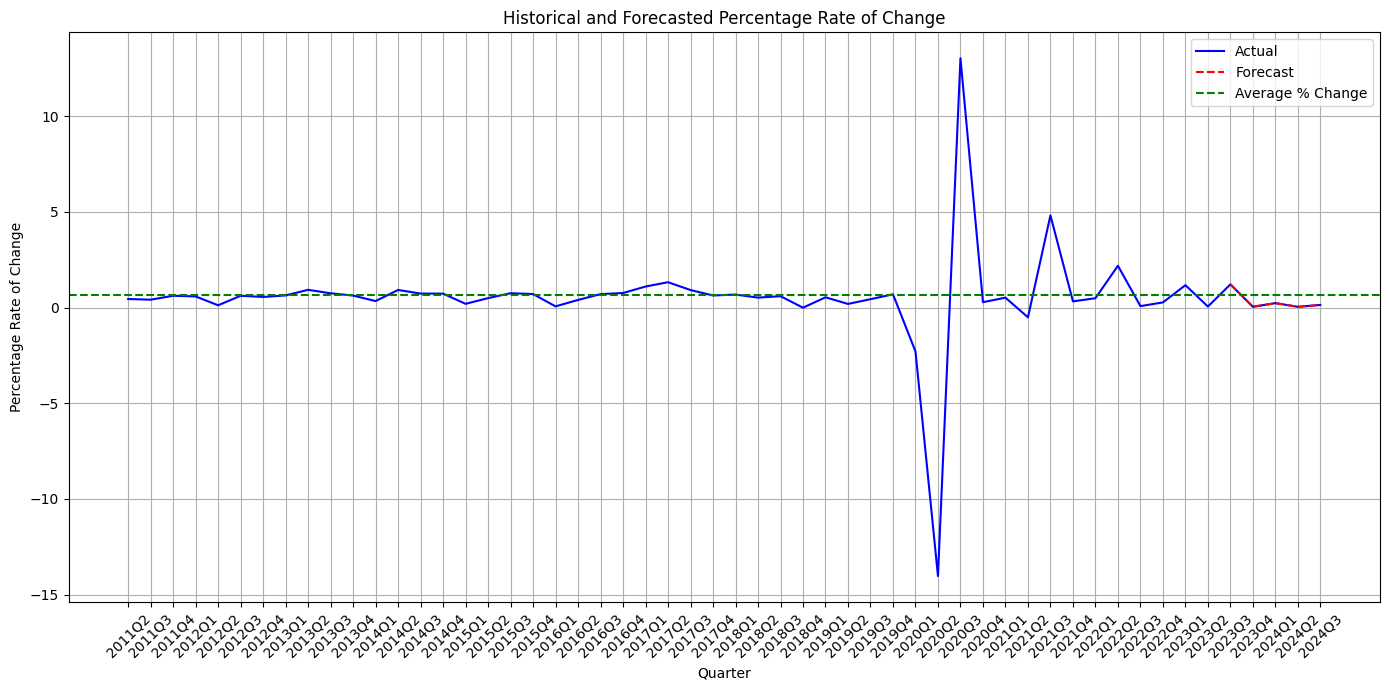

In [38]:
# Calculate the historical percentage rate of change for the entire dataset
historical_pct_change = (data['Household final consumption expenditure  [C]_diff'] / data['Household final consumption expenditure  [C]'].shift(1)) * 100

# Combined indices and values for both historical and forecasted data
combined_index_str = historical_pct_change.index.tolist() + forecasted_pct_change_final_corrected.index.tolist()
combined_values = historical_pct_change.tolist() + forecasted_pct_change_final_corrected.tolist()

# Create the visualization
plt.figure(figsize=(14, 7))

plt.plot(combined_index_str[80:], combined_values[80:], label='Actual', color='blue')

# Overlay the forecasted data
forecast_index = forecasted_pct_change_final_corrected.index
plt.plot(forecast_index, forecasted_pct_change_final_corrected.values, label='Forecast', color='red', linestyle='--')

# Display the average percentage change
plt.axhline(y=average_pct_change, color='green', linestyle='--', label='Average % Change')

# Other plot settings
plt.title('Historical and Forecasted Percentage Rate of Change')
plt.xlabel('Quarter')
plt.ylabel('Percentage Rate of Change')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

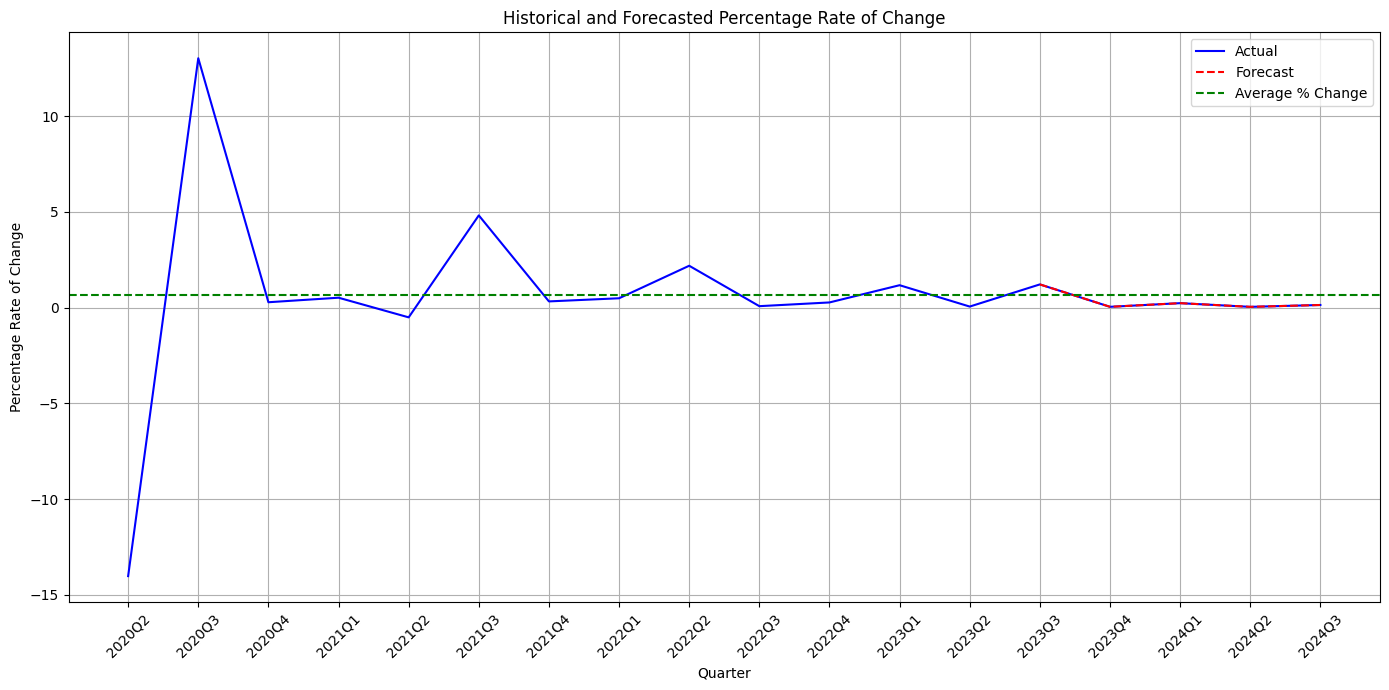

In [35]:
import matplotlib.pyplot as plt

# Create the visualization
plt.figure(figsize=(14, 7))

# Plot the historical data from 2019 onwards (assuming you start from the 80th data point)
plt.plot(combined_index_str[116:], combined_values[11:], label='Actual', color='blue')

# Overlay the forecasted data
forecast_index = forecasted_pct_change_final_corrected.index
plt.plot(forecast_index, forecasted_pct_change_final_corrected.values, label='Forecast', color='red', linestyle='--')

# Display the average percentage change
plt.axhline(y=average_pct_change, color='green', linestyle='--', label='Average % Change')

# Other plot settings
plt.title('Historical and Forecasted Percentage Rate of Change')
plt.xlabel('Quarter')
plt.ylabel('Percentage Rate of Change')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()